# TP 2- Conditionnement et Décomposition PA=LU
## Analyse Numérique Matricielle
### Polytech SU, 2023-2024


In [233]:
import numpy as np
from scipy.linalg import hilbert
import matplotlib.pyplot as plt

def tri_inf(matrice, vecteur):
    n = len(vecteur)
    x = np.zeros(n)

    # Vérification si la matrice est bien triangulaire inférieure
    for i in range(n):
        x[i] = (vecteur[i] - np.dot(matrice[i][:i], x[:i])) / matrice[i][i]

    return x

def tri_sup(matrice, vecteur):
    n = len(vecteur)
    x = np.zeros(n)

    for i in range(n-1, -1, -1):
        x[i] = (vecteur[i] - np.dot(matrice[i][i+1:], x[i+1:])) / matrice[i][i]

    return x


### Exercice 1

Soit

$$ A=\begin{pmatrix}
\epsilon &1\\1&10
\end{pmatrix}. $$

1. Calculer à la main les deux décompositions $PA=LU$ de $A$.

1. On a
$$
P = \begin{pmatrix} 0&1\\1&0 \end{pmatrix} \quad L=\begin{pmatrix} 1&0\\\epsilon &1 \end{pmatrix} \quad  U=\begin{pmatrix} 1&10\\0&1- 10\epsilon \end{pmatrix} 
$$
et
$$
P_2 = \begin{pmatrix} 1&0 \\0 & 1 \end{pmatrix} \quad L_2=\begin{pmatrix} 1&0\\ 1/ \epsilon &1 \end{pmatrix} \quad   U=\begin{pmatrix} \epsilon&1\\0& 10 -1/\epsilon \end{pmatrix} 
$$

2. Dans chacun des cas, pour $\epsilon = 10^{-2},10^{-3},10^{-4},10^{-5}$, calculer les conditionnements de U et de L. Les réprésenter sur un graphique. On pourra utiliser la fonction `cond` de `linalg`. 

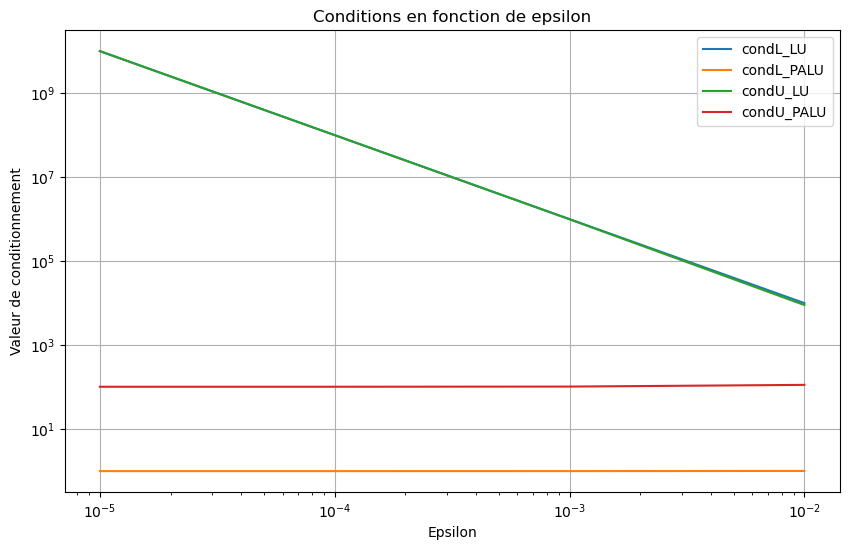

In [238]:
epsilons=[10**(-2),10**(-3),10**(-4),10**(-5)]
condL_LU=[]
condL_PALU=[]
condU_LU=[]
condU_PALU=[]
for epsilon in epsilons: 
    L2=np.array([[1,0],[1/epsilon,1]])
    L=np.array([[1,0],[epsilon,1]])
    U=np.array([[1,10],[0,1-10*epsilon]])
    U2=np.array([[epsilon,1],[0,10-1/epsilon]])
    condU_PALU.append(np.linalg.cond(U, p=2))
    condU_LU.append(np.linalg.cond(U2, p=2))
    condL_PALU.append(np.linalg.cond(L, p=2))
    condL_LU.append(np.linalg.cond(L2, p=2))

# Tracer les graphiques
plt.figure(figsize=(10, 6))

plt.loglog(epsilons, condL_LU, label='condL_LU')
plt.loglog(epsilons, condL_PALU, label='condL_PALU')
plt.loglog(epsilons, condU_LU, label='condU_LU')
plt.loglog(epsilons, condU_PALU, label='condU_PALU')

plt.title('Conditions en fonction de epsilon')
plt.xlabel('Epsilon')
plt.ylabel('Valeur de conditionnement')
plt.legend()
plt.grid(True)
plt.show()

3. On prend maintenant $\epsilon = 10^{-3}$. Utiliser la fonction `lu`de `linalg`. Que constatez-vous?

In [239]:
# 3. Utiliser scipy pour obtenir la décomposition LU
import numpy as np
from scipy.linalg import lu
epsilon=10**(-3)
A = np.array([[epsilon, 1], [1, 10]])

P, L, U = lu(A)

print("P:\n", P)
print("L:\n", L)
print("U:\n", U)



P:
 [[0. 1.]
 [1. 0.]]
L:
 [[1.    0.   ]
 [0.001 1.   ]]
U:
 [[ 1.   10.  ]
 [ 0.    0.99]]


4. On considère maintenant $b = \begin{pmatrix}2 \\2 \end{pmatrix}$. Résoudre $Ax = b$ à l'aide des deux décompositions précédentes. On utilisera les fonctions `tri_inf` et `tri_sup`. Comparer avec la vraie solution $x_{true} = \frac{1}{10\epsilon -1} \begin{pmatrix} 18 \\ 2\epsilon -2\end{pmatrix}$ pour $\epsilon = 10^{-2},10^{-3},10^{-4},10^{-5}$. On tracera les erreurs sur un même graphique.

[3.580361673049448e-15, 3.580361673049448e-15, 0.0, 4.440892098500626e-16]


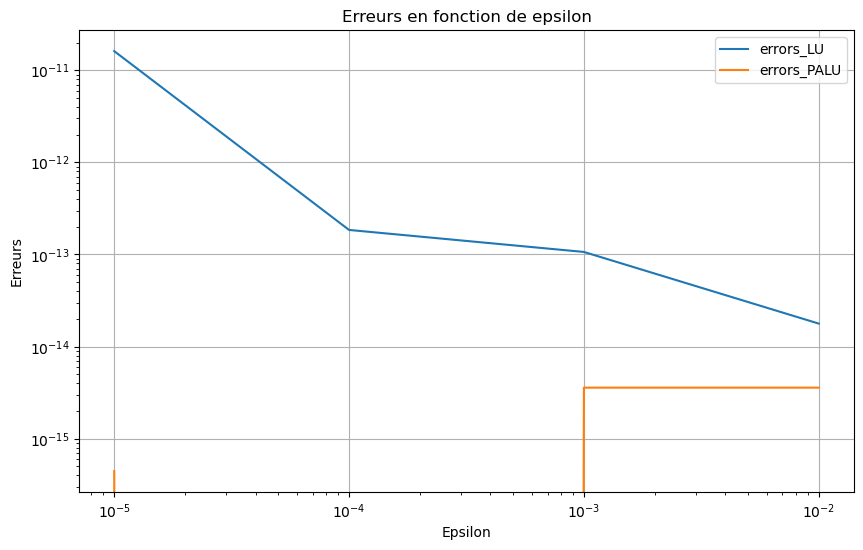

In [240]:
### résolution
errors_LU=[]
errors_PALU=[]

epsilon=0.001

for epsilon in epsilons:
    L2=np.array([[1,0],[1/epsilon,1]])
    U2=np.array([[epsilon,1],[0,10-1/epsilon]])
    A = np.array([[epsilon, 1], [1, 10]])
    P, L, U = lu(A)
    x_true= 1/(10*epsilon -1)*np.array([18 ,2*epsilon-2])
    b=np.array([2,2])
    y = tri_inf(L,P@b)
    x = tri_sup(U,y)
    y2 = tri_inf(L2,b)
    x2 = tri_sup(U2,y2)
    errors_PALU.append(np.linalg.norm(x-x_true))
    errors_LU.append(np.linalg.norm(x2-x_true))

print(errors_PALU) 
plt.figure(figsize=(10, 6))

plt.loglog(epsilons, errors_LU, label='errors_LU')
plt.loglog(epsilons, errors_PALU, label='errors_PALU')

plt.title('Erreurs en fonction de epsilon')
plt.xlabel('Epsilon')
plt.ylabel('Erreurs')
plt.legend()
plt.grid(True)
plt.show()

### Exercice 2. 

Coder la fonction qui renvoie la décomposition $PA = LU$ d'une matrice $A$.  Attention, bien faire attention à prendre le coefficient avec la plus grande valeur absolue à chaque étape. On pourra s'aider des fonctions `np.abs`et `np.argmax`. Comparer avec le résultat obtenu avec la fonction `lu`.

In [241]:
## Décomposition PA=LU

def lu_decomposition(A):
    n = A.shape[0]
    P = np.eye(n)
    L = np.eye(n)
    U = A.copy()

    for k in range(n - 1):
        # Échange de lignes pour le pivot
        max_row = np.argmax(np.abs(U[k:, k])) + k
        U[[k, max_row], :] = U[[max_row, k], :]
        P[[k, max_row], :] = P[[max_row, k], :]
        L[[k, max_row], :k] = L[[max_row, k], :k]

        # Élimination
        for i in range(k + 1, n):
            factor = U[i, k] / U[k, k]
            U[i, k:] -= factor * U[k, k:]
            L[i, k] = factor

    return P, L, U



#### test
P1, L1, U1 = lu_decomposition(A)
print(P1-P)
print(L1-L)
print(U1-U)

[[0. 0.]
 [0. 0.]]
[[0. 0.]
 [0. 0.]]
[[0. 0.]
 [0. 0.]]
